## Imports and Config

In [1]:
import gymnasium as gym
import numpy as np
from scipy.special import softmax

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from collections import namedtuple, deque
import datetime

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
BUFFER_SIZE = 100000
BATCH_SIZE = 64
GAMMA = 0.99
LR = 0.0005
LR2 = 0.001
UPDATE_EVERY = 20

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Monte-Carlo REINFORCE

- Monte-Carlo REINFORCE is a policy-based method that uses a Monte-Carlo estimate of the return to update the policy.

- The policy is updated in the direction that increases the probability of the action that was taken.

In [4]:
class VNetwork(nn.Module):

    def __init__(
        self,
        state_size: int,
        seed: int = 0,
        n_hidden_layers: int = 2,
        hidden_layer_size: int = 128,
    ):
        """Initialize parameters and build model."""
        super(VNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_layer = nn.Linear(state_size, hidden_layer_size)
        self.hidden_layers = nn.ModuleList(
            [
                nn.Linear(hidden_layer_size, hidden_layer_size)
                for _ in range(n_hidden_layers)
            ]
        )
        self.output_layer = nn.Linear(hidden_layer_size, 1)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Build a network that maps state -> action values."""
        x = F.relu(self.input_layer(state))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        return self.output_layer(x)

In [5]:
class MCR_Network(nn.Module):

    def __init__(
        self,
        state_size: int,
        action_size: int,
        seed: int = 0,
        n_hidden_layers: int = 0,
        hidden_layer_size: int = 128,
    ):
        """Initialize parameters and build model."""
        super(MCR_Network, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.state_size = state_size
        self.action_size = action_size
        self.input_layer = nn.Linear(state_size, hidden_layer_size)
        self.hidden_layers = nn.ModuleList(
            [
                nn.Linear(hidden_layer_size, hidden_layer_size)
                for _ in range(n_hidden_layers)
            ]
        )
        self.output_layer = nn.Linear(hidden_layer_size, action_size)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Build a network that maps state -> action values."""

        x = F.relu(self.input_layer(state))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        return F.softmax(self.output_layer(x), dim=1)

    def get_action(self, state):
        """Get action from state using the policy"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action_values = self.forward(state)
        chosen_action = random.choices(
            range(self.action_size), weights=action_values.cpu().data.numpy().squeeze()
        )[0]
        log_p = torch.log(action_values.squeeze(0)[chosen_action])
        return chosen_action, log_p

### Replay Buffer

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object."""

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Monte-Carlo REINFORCE Agent

- `act()` - returns an action given a state

- `learn()` - updates the Q-Network based on the experience tuple.

In [7]:
class MC_Agent:

    def __init__(
        self,
        state_size: int,
        action_size: int,
        seed: int,
        n_hidden_layers: int = 2,
        hidden_layer_size: int = 128,
        learning_rate: float = LR,
        baseline: bool = False,
    ):
        """Agent-Environment Interaction"""
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        random.seed(seed)
        self.n_hidden_layers = n_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.learning_rate = learning_rate

        """ MC-network """
        self.mc_network = MCR_Network(
            state_size, action_size, seed, n_hidden_layers, hidden_layer_size
        ).to(device)
        self.optimizer = optim.Adam(self.mc_network.parameters(), lr=learning_rate)

        """ Initialize time step (for updating every UPDATE_EVERY steps) """
        self.t_step = 0

        """ Collecing log of probabilities for gradient descent update """
        self.log_probs = []

        """ Storing rewards for updates """
        self.rewards_list = []

        """ Collecting all the visited states """
        self.states_list = []

        """ Replay Memory """
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        """ Baseline flag, if true, normalize with Value function obtained by TD(0) """
        self.baseline = baseline
        if self.baseline:
            self.v_network = VNetwork(
                self.state_size, seed, n_hidden_layers=2, hidden_layer_size=128
            ).to(device)
            self.v_optimizer = optim.Adam(
                self.v_network.parameters(), lr=self.learning_rate
            )
            self.v_network_target = VNetwork(
                self.state_size, seed, n_hidden_layers=2, hidden_layer_size=128
            ).to(device)
        else:
            self.v_network, self.v_optimizer, self.v_network_target = None, None, None

    def reset(self, seed: int = 0):

        self.seed = seed
        random.seed(seed)
        self.mc_network = MCR_Network(
            self.state_size,
            self.action_size,
            seed,
            self.n_hidden_layers,
            self.hidden_layer_size,
        ).to(device)
        self.optimizer = optim.Adam(self.mc_network.parameters(), lr=self.learning_rate)
        self.t_step = 0
        self.log_probs = []
        self.rewards_list = []
        self.states_list = []
        self.memory = ReplayBuffer(self.action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        if self.baseline:
            self.v_network = VNetwork(
                self.state_size, seed, n_hidden_layers=2, hidden_layer_size=128
            ).to(device)
            self.v_optimizer = optim.Adam(
                self.v_network.parameters(), lr=self.learning_rate
            )
            self.v_network_target = VNetwork(
                self.state_size, seed, n_hidden_layers=2, hidden_layer_size=128
            ).to(device)
        else:
            self.v_network, self.v_optimizer, self.v_network_target = None, None, None

    def act(self, state: np.ndarray, tau: float) -> int:
        return self.mc_network.get_action(state)

    def step(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        log_prob: float,
        next_state: np.ndarray,
        done: bool,
        eps: int,
        gamma: float = GAMMA,
        refresh_count: int = 20,
    ):

        self.log_probs.append(log_prob)
        self.rewards_list.append(reward)
        self.states_list.append(state)

        """ Baseline with TD(0) update """
        if self.baseline:
            """ Store the experience in memory """
            self.memory.add(state, action, reward, next_state, done)
            """ If enough samples are available in memory, get random subset and learn """
            if len(self.memory) >= BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn_V(experiences, gamma)
            """ Update target network """
            if (eps + 1) % refresh_count == 0:
                self.v_network_target.load_state_dict(self.v_network.state_dict())

        if done:
            self.learn(gamma=GAMMA)
            return

    def learn_V(self, experiences: namedtuple, gamma: float = GAMMA):
        
        """ Get target and expected V values """
        states, actions, rewards, next_states, dones = experiences
        V_targets_next = (
            self.v_network_target(next_states).detach().max(1)[0].unsqueeze(1)
        )
        V_targets = rewards + (gamma * V_targets_next * (1 - dones))
        V_expected = self.v_network(states)

        """ Compute loss and update """
        loss = F.mse_loss(V_expected, V_targets)
        self.v_optimizer.zero_grad()
        loss.backward()
        self.v_optimizer.step()

    def learn(self, gamma: float = GAMMA):

        """ Compute the returns G_t for each time step """
    
        G_t = np.zeros(len(self.log_probs))
        val = 0
        for i in range(len(self.log_probs) - 1, -1, -1):
            val *= gamma
            val += self.rewards_list[i]
            G_t[i] = val

            if self.baseline:
                state_on_device = (
                    torch.from_numpy(self.states_list[i]).float().to(device)
                )
                G_t[i] -= self.v_network_target(state_on_device).cpu().detach().numpy()

        G_t = torch.Tensor(G_t).to(device)
        gradient = [-G_t[i] * self.log_probs[i] for i in range(len(self.log_probs))]

        self.optimizer.zero_grad()
        gradient = torch.stack(gradient).sum()
        gradient.backward()
        self.optimizer.step()

## Trainer

- The Trainer class is used to train an `agent` in a given environment `env`.

- It has a `train` method, where the agent interacts with the environment and learns from the experience.

In [8]:
class MC_Trainer:

    def __init__(self, agent: MC_Agent, env: gym.Env, threshold: float = 195.0):
        self.agent = agent
        self.env = env
        self.threshold = threshold
        self.scores_mean = []
        self.scores_std = []

    def train_single_run(
        self,
        seed: int = 0,
        n_episodes: int = 2000,
        max_t: int = 1000,
        tau_start: float = 1.0,
        tau_end: float = 0.01,
        tau_decay: float = 0.995,
        render: bool = False,
    ):

        self.agent.seed = random.seed(seed)
        scores_window = deque(maxlen=100)
        scores_list = []
        tau = tau_start

        for i_episode in range(1, n_episodes + 1):
            state, _ = self.env.reset()
            score = 0
            self.agent.log_probs.clear()
            self.agent.rewards_list.clear()

            for t in range(max_t):
                action, log_p = self.agent.act(state, tau)
                next_state, reward, done, _, _ = self.env.step(action)
                self.agent.step(
                    state, action, reward, log_p, next_state, done, i_episode
                )
                state = next_state
                score += reward
                if done:
                    break

            scores_window.append(score)
            scores_list.append(score)

            tau = max(tau_end, tau_decay * tau)

            print(
                f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}",
                end="",
            )

            if i_episode % 100 == 0:
                print(
                    f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}"
                )
            if np.mean(scores_window) >= self.threshold:
                print(
                    f"\nEnvironment solved in {i_episode} episodes!\tAverage Score: {np.mean(scores_window):.2f}"
                )
                torch.save(self.agent.mc_network.state_dict(), "checkpoint.pth")
                break
            if i_episode > 100 and np.mean(scores_window) <= -9000:
                print(
                    f"\nEnvironment not solved in {i_episode} episodes. Average Score: {np.mean(scores_window):.2f}"
                )
                scores_list = []
                break

        return scores_list

    def train_multiple_runs(
        self,
        n_runs: int = 5,
        seed_arr: np.ndarray = [0, 1, 2, 3, 4],
        n_episodes: int = 2000,
        max_t: int = 10000,
        tau_start: float = 1.0,
        tau_end: float = 0.01,
        tau_decay: float = 0.995,
        render: bool = False,
    ):
        all_scores = []
        i = 0
        while i < n_runs:

            print(f"RUN {i+1}")
            self.agent.reset(seed_arr[i])

            print(f"Seed: {self.agent.seed}")
            print(f"Baseline: {self.agent.baseline}")
            print(f"Hidden Layers: {self.agent.n_hidden_layers}")
            print(f"NUM Hidden Layers: {len(self.agent.mc_network.hidden_layers)}")
            print(f"Hidden Layer Size: {self.agent.hidden_layer_size}")
            print(f"Learning Rate: {self.agent.learning_rate}")

            begin_time = datetime.datetime.now()
            scores = self.train_single_run(
                seed_arr[i], n_episodes, max_t, tau_start, tau_end, tau_decay, render
            )
            end_time = datetime.datetime.now()

            print(f"Time taken: {end_time - begin_time}")
            print("*" * 50)
            print(np.mean(scores), np.max(scores), np.min(scores))
            all_scores.append(scores)
            i += 1

        max_episode = max([len(scores) for scores in all_scores])

        all_scores = [
            scores + [np.mean(scores[-10:])] * (max_episode - len(scores))
            for scores in all_scores
        ]
        self.scores_mean = np.mean(all_scores, axis=0)
        self.scores_std = np.std(all_scores, axis=0)

### Setting random seeds

In [9]:
N_RUNS = 5
seed_arr = sorted([int(np.random.randint(0, 1000)) for _ in range(N_RUNS)])
print(seed_arr)


def my_avg(scores, window=3):
    return np.array(
        [np.mean(scores[i : i + window]) for i in range(len(scores) - window)]
    )

[85, 327, 383, 523, 566]


### Example Usage

In [ ]:
env = gym.make("Acrobot-v1")
state_size = env.observation_space.shape[0]
n_actions = env.action_space.n
env.reset(seed=0)

agent = MC_Agent(
    state_size=state_size,
    action_size=n_actions,
    seed=0,
    n_hidden_layers=2,
    hidden_layer_size=128,
    learning_rate=0.0005,
    baseline=True,
)

trainer = MC_Trainer(agent, env, threshold=-100)
trainer.train_multiple_runs(n_runs=N_RUNS, seed_arr=seed_arr)

In [1]:
hidden_layer_size_params = [64, 128]
n_hidden_layers_params = [1]
learning_rate_params = [0.001]
baseline_params = [False, True]

param_grid = [
    (hidden_layer_size, n_hidden_layers, learning_rate, baseline)
    for hidden_layer_size in hidden_layer_size_params
    for n_hidden_layers in n_hidden_layers_params
    for learning_rate in learning_rate_params
    for baseline in baseline_params
]

trainer_list = []
for params in param_grid:
    hidden_layer_size, n_hidden_layers, learning_rate, baseline = params
    env = gym.make("Acrobot-v1")
    state_size = env.observation_space.shape[0]
    n_actions = env.action_space.n
    env.reset(seed=0)

    agent = MC_Agent(
        state_size=state_size,
        action_size=n_actions,
        seed=0,
        n_hidden_layers=n_hidden_layers,
        hidden_layer_size=hidden_layer_size,
        learning_rate=learning_rate,
        baseline=baseline,
    )

    trainer = MC_Trainer(agent, env, threshold=-100)
    trainer.train_multiple_runs(n_runs=N_RUNS, seed_arr=seed_arr, max_t=10000)
    trainer_list.append(trainer)

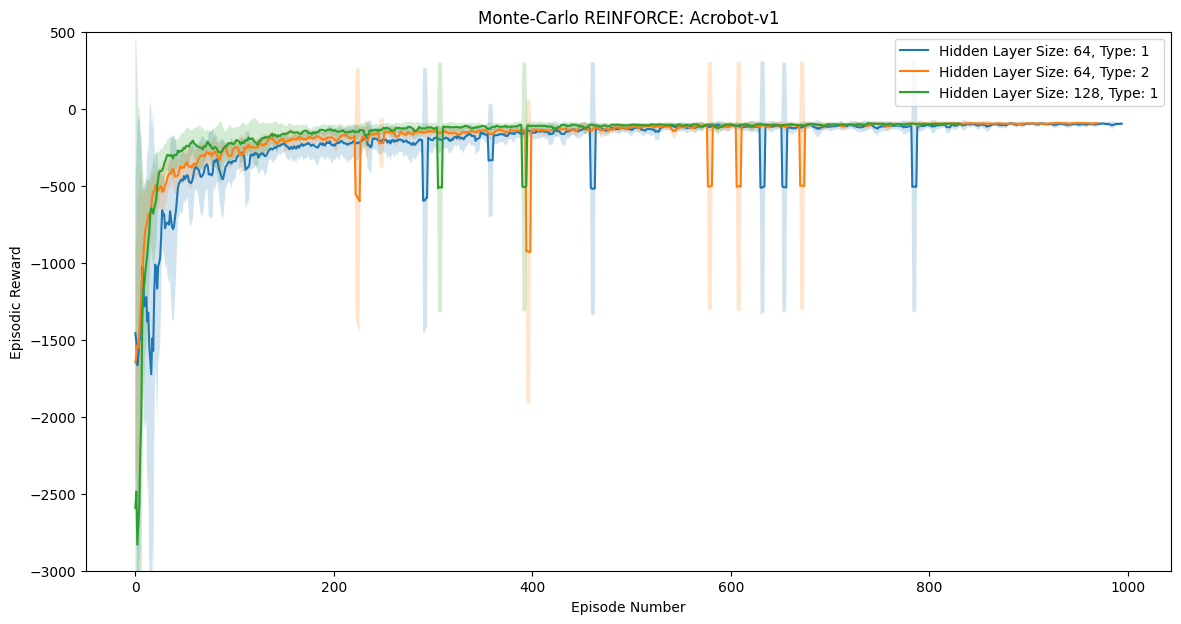

In [26]:
plt.figure(figsize=(14, 7))

for i, trainer in enumerate(trainer_list):

    if i==2:
        continue

    mean_arr = trainer.scores_mean
    std_arr = trainer.scores_std
    if len(mean_arr) > 1000:
        mean_arr = mean_arr[:1000]
        std_arr = std_arr[:1000]
    mean_arr = my_avg(mean_arr, window=5)
    std_arr = my_avg(std_arr, window=5)
    num_neurons = param_grid[i][0]
    t = 1 + param_grid[i][3]

    plt.plot(mean_arr, label=f"Type: {t}")
    plt.fill_between(
        range(len(mean_arr)),
        mean_arr - std_arr,
        mean_arr + std_arr,
        alpha=0.2,
    )

plt.legend()
plt.title("Monte-Carlo REINFORCE: Acrobot-v1")
plt.xlabel("Episode Number")
plt.ylabel("Episodic Reward")
plt.ylim(-3000,500)
plt.show()